## The parallel Package

This chapter will dive deeper into the parallel package. You'll learn about the various backends and their differences and get a deep understanding about the workhorse of the package, namely the clusterApply() function. Strategies for task segmentation including their pitfalls will also be discussed

### Exploring the cluster object
In this exercise, you will explore the cluster object created by makeCluster(). In addition, you will use clusterCall(), which evaluates a given function on all workers. This can be useful, for example, when retrieving information from workers.

clusterCall() takes two arguments: the cluster object and the function to apply to each worker node. Just like lapply(), the function is passed without parentheses.

Here, we will use clusterCall() to determine the process ID of the workers, which is equivalent to finding process IDs of R sessions spawned by the master. Such info could be used for process management, including things outside of R.

In [3]:
# Load the parallel package
library(parallel)

# Make a cluster with 4 nodes
cl <- makeCluster(4)

# Investigate the structure of cl
str(cl)

# What is the process ID of the workers?
clusterCall(cl, Sys.getpid)
# Stop the cluster
stopCluster(cl)

List of 4
 $ :List of 3
  ..$ con : 'sockconn' int 8
  .. ..- attr(*, "conn_id")=<externalptr> 
  ..$ host: chr "localhost"
  ..$ rank: int 1
  ..- attr(*, "class")= chr "SOCKnode"
 $ :List of 3
  ..$ con : 'sockconn' int 9
  .. ..- attr(*, "conn_id")=<externalptr> 
  ..$ host: chr "localhost"
  ..$ rank: int 2
  ..- attr(*, "class")= chr "SOCKnode"
 $ :List of 3
  ..$ con : 'sockconn' int 10
  .. ..- attr(*, "conn_id")=<externalptr> 
  ..$ host: chr "localhost"
  ..$ rank: int 3
  ..- attr(*, "class")= chr "SOCKnode"
 $ :List of 3
  ..$ con : 'sockconn' int 11
  .. ..- attr(*, "conn_id")=<externalptr> 
  ..$ host: chr "localhost"
  ..$ rank: int 4
  ..- attr(*, "class")= chr "SOCKnode"
 - attr(*, "class")= chr [1:2] "SOCKcluster" "cluster"


[[1]]
[1] 15744

[[2]]
[1] 6424

[[3]]
[1] 6276

[[4]]
[1] 14032

### Socket vs. Fork
Now we will explore differences between the socket and the fork backends. In a fork cluster, each worker is a copy of the master process, whereas socket workers start with an empty environment. We define a global object and check if workers have an access to it under each of the backends. Your job is to use the function clusterCall() to look for the global object in the workers' environment.

The package parallel and the print_global_var() function, which calls print(a_global_var), are available in your workspace.

In [6]:
# A global variable and is defined
a_global_var <- "before"

print_global_var <- function() {
    print(a_global_var)
}

# Create a socket cluster with 2 nodes
cl_sock <- makeCluster(2, type = "PSOCK")

# Evaluate the print function on each node
clusterCall(cl_sock,print_global_var)

# Stop the cluster
stopCluster(cl_sock)

ERROR: Error in checkForRemoteErrors(lapply(cl, recvResult)): 2 nodes produced errors; first error: object 'a_global_var' not found


In [7]:
# A global variable and is defined
a_global_var <- "before"

# Create a fork cluster with 2 nodes
cl_fork <- makeCluster(2, type = "FORK")

# Evaluate the print function on each node
clusterCall(cl_fork, print_global_var)

# Stop the cluster
stopCluster(cl_fork)

ERROR: Error in makeForkCluster(nnodes = spec, ...): fork clusters are not supported on Windows


In [ ]:
# A global variable and is defined
a_global_var <- "before"

# Create a fork cluster with 2 nodes
cl_fork <- makeCluster(2, type = "FORK")

# Change the global var to "after"
a_global_var <- "after"

# Evaluate the print fun on each node again
clusterCall(cl_fork, print_global_var)

# Stop the cluster
stopCluster(cl_fork)

# Socket clusters are initialized without variables, so a_global_var wasn't found. 
# Fork clusters take a copy of global variables, but changes made after the cluster is 
# created are not copied to each node.

### Benchmarking setup
In this exercise, you will take the simple embarrassingly parallel application for computing mean of random numbers (mean_of_rnorm()) from the first chapter, and implement two functions: One that runs the application sequentially, mean_of_rnorm_sequentially(), and one that runs it in parallel, mean_of_rnorm_in_parallel(). We will then benchmark these two functions in the next exercise.

mean_of_rnorm() and a cluster object, cl, are defined.

In [9]:
# define mean_of_rnorm
mean_of_rnorm <- function(n) {
  # Generate normally distributed random numbers
  random_numbers <- rnorm(n)
  # Calculate the mean of the random numbers
  mean(random_numbers)
}

# Wrap this code into a function
mean_of_rnorm_sequentially <- function(n_numbers_per_replicate, n_replicates){
n <- rep(n_numbers_per_replicate, n_replicates)
lapply(n, mean_of_rnorm)
}

# Call it to try it
mean_of_rnorm_sequentially(1000, 5)

[[1]]
[1] -0.008562365

[[2]]
[1] -0.002084149

[[3]]
[1] -0.01420934

[[4]]
[1] -0.01969963

[[5]]
[1] 0.04382083

In [11]:
# Make a cluster with 2 nodes
cl <- makeCluster(2)

# Wrap this code into a function
mean_of_rnorm_in_parallel <- function(n_numbers_per_replicate, n_replicates){
n <- rep(n_numbers_per_replicate, n_replicates)
clusterApply(cl, n, mean_of_rnorm) 
}

# Call it to try it
mean_of_rnorm_in_parallel(1000, 5)

[[1]]
[1] -0.02736177

[[2]]
[1] 0.03291422

[[3]]
[1] -0.03985754

[[4]]
[1] 0.00874318

[[5]]
[1] -0.004935544

### Task size matters
Now you will benchmark the functions created in the previous exercise using the microbenchmark package. To see the impact of the parallel processing overhead, you will pass different number of replications and sample sizes and explore under which conditions parallel processing becomes inefficient.

mean_of_rnorm_sequentially(), mean_of_rnorm_in_parallel(), and a cluster cl with two nodes are available.

In [14]:
# install.packages("microbenchmark")
library(microbenchmark)

# Set numbers per replicate to 5 million
n_numbers_per_replicate <- 5000000

# Set number of replicates to 4
n_replicates <- 4

# Run a microbenchmark
microbenchmark(
  # Call mean_of_rnorm_sequentially()
  mean_of_rnorm_sequentially(n_numbers_per_replicate, n_replicates) , 
  # Call mean_of_rnorm_in_parallel()
  mean_of_rnorm_in_parallel(n_numbers_per_replicate, n_replicates),
  times = 1, 
  unit = "s"
)

package 'microbenchmark' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Migue\AppData\Local\Temp\RtmpKQRv0s\downloaded_packages


Warning message:
"package 'microbenchmark' was built under R version 3.6.3"

expr,time
"mean_of_rnorm_in_parallel(n_numbers_per_replicate, n_replicates)",547817800
"mean_of_rnorm_sequentially(n_numbers_per_replicate, n_replicates)",1060278800


In [15]:
# Change the numbers per replicate to 100
n_numbers_per_replicate <- 100

# Change number of replicates to 100
n_replicates <- 100

# Rerun the microbenchmark
microbenchmark(
  mean_of_rnorm_sequentially(n_numbers_per_replicate, n_replicates), 
  mean_of_rnorm_in_parallel(n_numbers_per_replicate, n_replicates),
  times = 1, 
  unit = "s"
)

expr,time
"mean_of_rnorm_in_parallel(n_numbers_per_replicate, n_replicates)",13505001
"mean_of_rnorm_sequentially(n_numbers_per_replicate, n_replicates)",1063801


In [ ]:
## We saw a speed-up when the independent tasks were large and the communication overhead low. 
## We saw a significant inefficiency when the sample size was small

### Loading package on nodes
In this example, you will run a simple application in parallel that requires the package extraDistr. You will see that if you load it only on the master, the code will fail. Then you will use the function clusterEvalQ() to load the package on all cluster nodes.

The parallel package and a 4-node cluster object cl with socket backend is available in your workspace. You will use a pre-defined function myrdnorm() that takes n, mean, and sd as arguments and passes it to the rdnorm() function from extraDistr to generate n random numbers from the discrete normal distribution with given mean and standard deviation.

In [23]:
# Pre-defined myrdnorm 
myrdnorm <- function(n, mean = 0, sd = 1) 
    rnorm(n, mean = mean, sd = sd)

# Parameters
n_numbers_per_replicate <- 1000
n_replicates <- 20

# Repeat n_numbers_per_replicate, n_replicates times
n <- rep(n_numbers_per_replicate, n_replicates)

# Load extraDistr on master
# install.packages("extraDistr")
library(extraDistr)

# Run myrdnorm in parallel. This should fail!
res <- clusterApply(cl,n, myrdnorm)

[[1]]
[1] "extraDistr" "stats"      "graphics"   "grDevices"  "utils"     
[6] "datasets"   "methods"    "base"      

[[2]]
[1] "extraDistr" "stats"      "graphics"   "grDevices"  "utils"     
[6] "datasets"   "methods"    "base"

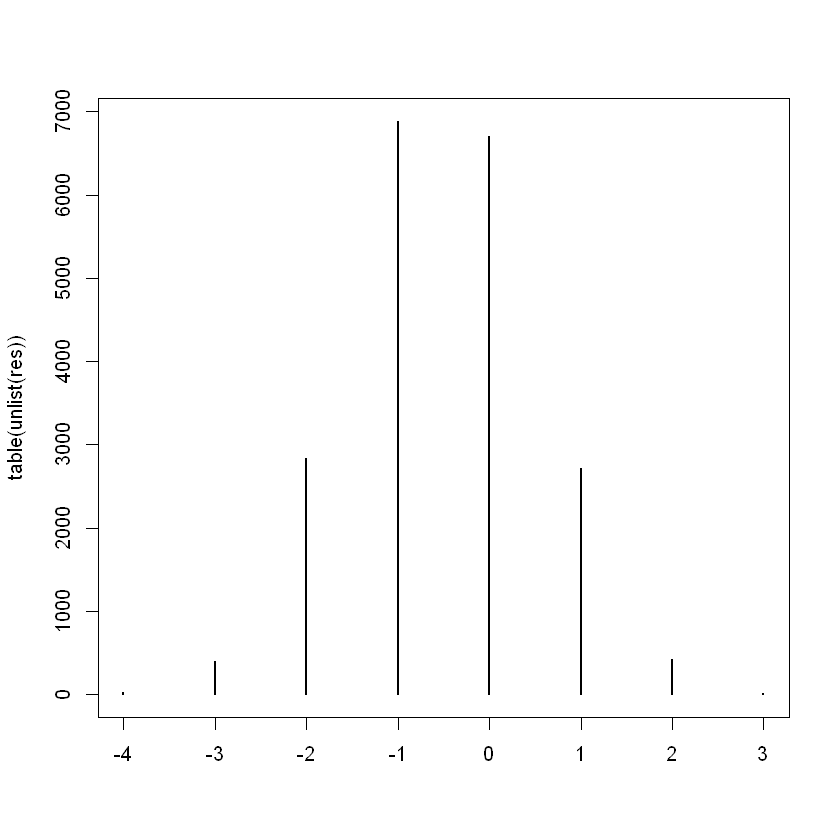

In [20]:
# From previous step
myrdnorm <- function(n, mean = 0, sd = 1) 
    rdnorm(n, mean = mean, sd = sd)
n_numbers_per_replicate <- 1000
n_replicates <- 20
n <- rep(n_numbers_per_replicate, n_replicates)

# Load extraDistr on master
library(extraDistr)

# Load extraDistr on all workers
clusterEvalQ(cl, library(extraDistr))
# Run myrdnorm in parallel. It should work now!
res <- clusterApply(cl,n,myrdnorm)

# Plot the result
plot(table(unlist(res)))

### Setting global variables
Here you will use a slight modification of the previous example, where instead of passing the mean and sd parameters as arguments, they will be defined in the worker's environment as global variables. You will use the clusterEvalQ() function again for the worker initialization.

As before, the parallel package and the cluster object cl are available in your workspace. A variant of myrdnorm() that uses global variables is shown in the script.

In [25]:
# rdnorm(), but using global variables
myrdnorm <- function(n) {
  rdnorm(n, mean = mean, sd = sd)
}

# Set mean to 10, globally
mean <- 10

# Set sd to 5, globally
sd <- 5

# Generate 1000 numbers with myrdnorm()
myrdnorm(1000)

[1] 16 14 10 15 -1  9 10 15  3  9  6  4 12 15 11  8  9 11 15 15  4  5 15 12
  [25] 13  5 15 18 16 -3  9  9 12  9 10  7  3  8  7 -1  9 13  1 10  5 12 19 18
  [49]  3 14 -4  0  6 11 13 17  9 11  6  7  5  8  9 16 17 15 11 12  7  7  4  4
  [73]  5  7 14 17  1 -2  9 12 11 10 13 -1  8 13 14  9 10  1  4 12 10 19 13 16
  [97]  9 17  0  5  5  7  6 12  3 14  6 18 13  8  4 20 10 16 15  5  4  9 14  9
 [121] 14 10  7 16 14 16 17  7 13  5  9  7 18 20 13 11 10 16 11  6 18  4 14  1
 [145] 10  9  3  1 23 17  4 13  9 -1 10  6  5 11  9  8 12  4  3  1  7  6  9  9
 [169] 20 12 11  9 16  9  5  3 11  7 10 12 12 10 11 13 11 17  9  3  7 10  6  4
 [193] 10  9  2  9  5 14 10  6 12  6  2  3 13  4 15  7 12  8 10  9  7  8 11  9
 [217] 13  6  4  2  7 18 -5  6 15 -2 11 16 10 15  9 12 12  2 11  0 11 10 17 15
 [241] 11 19  6  7 10 10 24 -1 11 15  7 15 10 21 12 12 18  6 18  5  6 12 16 15
 [265] 10 13 20  9 10  2 16 14  8 13 11  3 -3  1  9 11 10  7 10  6  7 12 16 -2
 [289] 10  9  8  8  5 14 17 15  9  8 14  6 16  3 10 13 11 13 20 17 11  8  6 12
 [313]  2  8  3  8 12  2  9 15 14 11  4 12 22 20  4  9  6  9 15  6 11 15 19  5
 [337] 19 12  6  8  8 20  7  9 18 11 11  6 11 12  6 15 13 11 19 11  6  9  5 11
 [361] 10 12  6 17 10  5  4  8 20 12 -1 12  9 16 14 15 15  8 10 11  8  9 14  9
 [385]  9  8 15  6 11 11 16  9 17 17 -6  2 12 10 14  6  7 14 17 11 17  6 15 12
 [409] 14  9 10 14  8  9  6  3  6  8 14 17 15 10  4 13 11 11  9 10 15  2 13 22
 [433] 23  9 15 14  4  9  8  7  9 11 12  4  6  6 14 10 12  9 11 13  2  9 10 11
 [457]  9  9 13  8 12  6  3 13 15  3 12 12 -2  3  8 17  6 12  5  5 14 11  9  5
 [481]  2 12 15  9  6 10 13  6 13 12  6  6 12 13  4  5 19 13 11 18 12  9 11 20
 [505] 17  9 10  8 10 12 16  8 11 13 13 13 13  2  8 13  3  9 16  4 14 -3 11  4
 [529] 13 10 11  1 21  7  5 12 13 12 12 10 12 19 12  6 11  5  1 11  4  6 11  2
 [553] 17  5 13 12 15  5  8  8  9 13 -6  2  9 12  4 12  9 14 17  8 11 17 18  4
 [577] 13 16 11  5  9 14  9 19 10 14 13  4 18  2  9  1 12  9 12 17 14 13 -1  8
 [601] 14  1 13  1 13  6 10  0 16 10  9  2  7 14 13  4  4 11  5 11 17 17  2 10
 [625] 11  7  8 10 14 12 13  8 10 13 -4 13  3 -2  8  8 11 13  7 14  5 16 13 15
 [649]  9  5 -2 10  6 10 10  5 14  6 14  8  6 11 12 16  6 13  5  4  8  6  9 13
 [673] 12 10 14  8  6 11  5  9  6  9  8  6  6  7  4  7  3  0 12 12 13  9  9  6
 [697] 14  6 15 11 12  6 15 10  8  6  4 10 19  3  3 11 20  7  3  5  3  2 10 10
 [721] 17  3 14 14  6  5 -4 11 12 20 16 14  6  3 19 14  7  5 12  4 14  5  7 20
 [745]  7 21  8  9 11  9 13  9 18 -3  8  7  2 11 13 10  6  5 15  0  5  9  6  9
 [769] 14 15 12  8  8 14 20 14 12 14 11 15 -3 10  5 10  8 -1  8 21  4 12  9  7
 [793]  3 21  9 13  6  3  9 11  7  6 13  3 17 11  7  9 10  4 16 14  5  1  8  2
 [817]  6 10 11 10 11 13 14  4 13  9  0  6  6 10 15 10  6  9  7  6 11 -5 13 16
 [841] 12 16  6 15  6 11 15 11 12 13 20 10 13  4 -4 10 12 14  0 11 10  4 18 12
 [865]  5  4 18  9  4  4  7  4 16 12 21 16 11 13 13 -5 12 10 14 12  9  5 10  2
 [889]  9 17  4 21 15 14 17  7  7  2 16 16  9  6  8 11 11 14  8  8 13  6 16 14
 [913]  3 16 10 14 12  0 10 14 12  1  1 -5 18 -1  7  6  2  7 12  2 12 10 11 16
 [937] 12  6 13 11 14  8  8 10 10 12 12  7 16 14  3 11  8 11  9 12 13  8  5  6
 [961]  6 22  8 11 15  0  4 15  8  6 15  5  5  6  7 14 13 18 12 11 10  6  5  8
 [985] 12 11 14 13 13  7  9  9 14  7 15  5 18  6 13  9

[[1]]
[1] 5

[[2]]
[1] 5

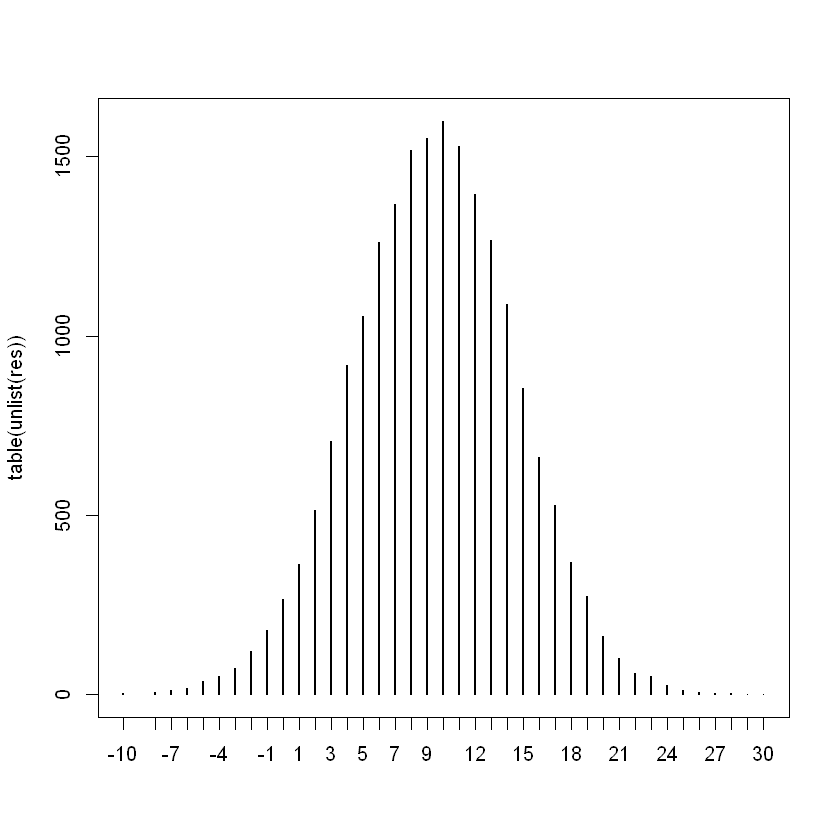

In [26]:
# From previous step
myrdnorm <- function(n) {
  rdnorm(n, mean = mean, sd = sd)
}

# Set number of numbers to generate
n <- rep(1000, 20)

# Run an expression on each worker
clusterEvalQ(
  cl, {
    # Load extraDistr
    library(extraDistr)
    # Set mean to 10
    mean <- 10
    # Set sd to 5
    sd <- 5
})

# Run myrdnorm in parallel
res <- clusterApply(cl,n, myrdnorm)

# Plot the results
plot(table(unlist(res)))

### Exporting global objects
Using clusterEvalQ() for setting global variables as in the last example assigns them only on the nodes and not on the master. If you want to share the same objects between master and the nodes, use the function clusterExport(). Here we use the same function as in the last exercise, myrdnorm() and initialize the global objects first on the master. Then you will use clusterExport() to export those objects to the workers.

clusterExport() takes two arguments: a cluster object and a character vector of variable names to copy from the master to the nodes.

The parallel package, a cluster object of size four, cl, the function myrdnorm(), and the number of numbers to generate, n, are available.

[[1]]
[1] "extraDistr" "stats"      "graphics"   "grDevices"  "utils"     
[6] "datasets"   "methods"    "base"      

[[2]]
[1] "extraDistr" "stats"      "graphics"   "grDevices"  "utils"     
[6] "datasets"   "methods"    "base"

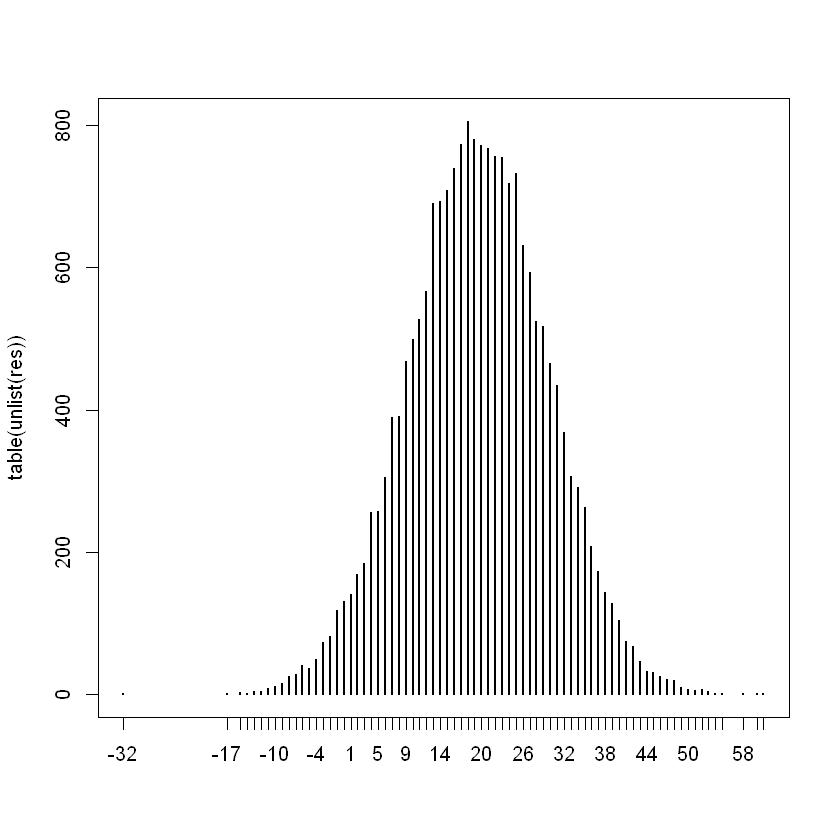

In [27]:
# Set global objects on master: mean to 20, sd to 10
mean <- 20
sd <- 10

# Load extraDistr on workers
clusterEvalQ(cl, library(extraDistr))

# Export global objects to workers
clusterExport(cl, varlist = c("mean", "sd"))
# Run myrdnorm in parallel
res <- clusterApply(cl, n, fun = myrdnorm)

# Plot the results
plot(table(unlist(res)))

### Passing data as arguments
Here, we will explore subsetting data by passing it to workers as arguments. We will use the Jane Austen example introduced previously. The goal is to find unique words within the 6 books from the janeaustenr package, that start with the given letter, here "v", and have the given number of characters or more, here at least 10. You will evaluate the task in parallel on a cluster of size 2. You will also split the set of words into 2 subsets so that each worker gets one of them.

The parallel package, the set of words extracted from janeaustenr, and a cluster object cl with 2 workers are available in your workspace. The function with the following arguments has also been defined for you:

select_words(words, letter, min_length)
select_words() extracts all words that start with letter and are of length min_length or more. Run the function in the console to see how it works.

In [32]:
library(tidyr)
library(janeaustenr)
library(stringr)

extract_words <- function(book_name) {
    # extract the text of the book
    text <- subset(austen_books(), book == book_name)$text
    # extract words from the text and convert to lowercase
    str_extract_all(text, boundary("word")) %>% unlist %>% tolower
}

janeausten_words <- function() {
    # Names of the six books contained in janeaustenr
    books <- austen_books()$book %>% unique %>% as.character
    # Vector of words from all six books
    words <- sapply(books, extract_words) %>% unlist
    words
}
# Vector of words from all six books
words <- janeausten_words()

select_words <- function(letter, words, min_length = 1) {
    min_length_words <- words[nchar(words) >= min_length]
    grep(paste0("^", letter), min_length_words, value = TRUE)
}

# Select words beginning with "v", at least 10 letters long
words_v10 <- select_words(letter = "v", words = words, min_length = 10 )

# Get the unique words
unique(words_v10)



[1] "voluntarily"    "variations"     "vindication"    "violoncello"   
 [5] "vouchsafed"     "veneration"     "volatility"     "volubility"    
 [9] "vigorously"     "villainous"     "vindicating"    "vulnerable"    
[13] "vicissitudes"   "vegetation"     "vulgarisms"     "valetudinarian"
[17] "vindicated"     "vouchsafing"    "voluminous"     "vehemently"    
[21] "valancourt"     "venerating"     "viscountess"    "vanquished"

In [33]:
# Generate 2 random groups
groups <- sample(x = 2, size = length(words), replace = TRUE)

# See those groups
head(groups, 20)

# Split words into groups
split_words <- split(words, groups)

# Apply select_words() to each element of split_words in parallel
res <- clusterApply(cl, split_words,select_words, letter = "v", min_length = 10)
 
# Flatten the result
words_v10 <- unlist(res)

# Get the unique words
unique(words_v10)

[1] 2 2 2 1 1 2 2 2 1 1 1 2 1 1 1 2 2 2 1 1

[1] "voluntarily"    "violoncello"    "vindication"    "vouchsafed"    
 [5] "veneration"     "volatility"     "villainous"     "volubility"    
 [9] "vindicating"    "vulnerable"     "vicissitudes"   "valetudinarian"
[13] "vigorously"     "vindicated"     "vouchsafing"    "voluminous"    
[17] "venerating"     "viscountess"    "vanquished"     "variations"    
[21] "vegetation"     "vulgarisms"     "vehemently"     "valancourt"

### Chunking migration application on worker's side
The migration application from the first chapter is an example of the third type of chunking, namely when the workers "see" the whole dataset and only get instructions which part of the data to work on. Here, you will parallelize the code. Earlier you defined a function ar1_multiple_blocks_of_trajectories() that takes a vector of row identifiers as an argument and generates migration trajectories using the corresponding rows of the parameter set ar1est.

ar1_multiple_blocks_of_trajectories() depends on ar1_block_of_trajectories() which in turn depends on ar1_one_trajectory(). These functions along with the cluster object cl of size 4, function show_migration(), the dataset ar1est (reduced to 200 rows) and packages parallel and ggplot2 are available in your workspace.

In [37]:
library(ggplot2)
ar1est = read.csv("US migration.csv", header = TRUE)

ar1_one_value <- function(est, r) {
    est['mu'] + est['phi'] * (r - est['mu']) + 
        rnorm(1, sd = est['sigma'])
}

ar1_one_trajectory <- function(est, rate0, len = 15) {
    trajectory <- rep(NA, len)
    rate <- rate0
    for (time in seq_len(len)) {
        trajectory[time] <- ar1_one_value(est, r = rate)
        rate <- trajectory[time]
    }
    trajectory
}

ar1_block_of_trajectories <- function(id, rate0 = 0.015, traj_len = 15, block_size = 10) {
    trajectories <- matrix(NA, nrow = block_size, ncol = traj_len)
    for (i in seq_len(block_size)) 
        trajectories[i,] <- ar1_one_trajectory(unlist(ar1est[id, ]), rate0 = rate0, len = traj_len)
    trajectories
}

# Function definition of ar1_multiple_blocks_of_trajectories()
ar1_multiple_blocks_of_trajectories <- function(ids, ...) {
  # Call ar1_block_of_trajectories() for each ids
  trajectories_by_block <- lapply(ids, ar1_block_of_trajectories, ...)
  
  # rbind results
  do.call(rbind,trajectories_by_block)
}

# Export data and functions
clusterExport(cl, c("ar1est", "ar1_one_trajectory", "ar1_block_of_trajectories"))

# Process ar1_multiple_blocks_of_trajectories in parallel
res_prev <- clusterApply(cl, 
                    1:nrow(ar1est), 
                    fun = ar1_multiple_blocks_of_trajectories)

# Combine results into a matrix and show results        
trajs <- do.call(rbind, res)
show_migration(trajs)

ERROR: Error in checkForRemoteErrors(val): 1000 nodes produced errors; first error: could not find function "ar1_one_value"


### Alternative chunking
We will now slightly modify the application of chunking in the previous exercise. Instead of a task corresponding to one row, each task will now process 40 rows, which corresponds to 5 tasks in total. You will then compare the shape of the returned object to the one you created in the last exercise. Recall that in both cases you are generating 10 trajectories per each of the 200 rows, which is 2000 trajectories in total, each 15 time points long.

The package parallel and cluster object cl with 4 workers along with all dependent functions and dataset have been exported to the workers. The object res returned by clusterApply() in the previous exercise is also in your workspace, now called res_prev.

In [ ]:
# Split task into 5 chunks
ind <- splitIndices(nrow(ar1est), 5)

# Process ar1_multiple_blocks_of_trajectories in parallel
res <- clusterApply(cl = cl, ind, ar1_multiple_blocks_of_trajectories)

# Compare the structure of the results 
str(res)
str(res_prev)